<a href="https://colab.research.google.com/github/beverast/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=297.947409891588, mobile=True), User(purchased=False, time_on_site=136.5376347316224, mobile=False), User(purchased=False, time_on_site=212.92111849109344, mobile=True), User(purchased=True, time_on_site=274.37338279635327, mobile=False), User(purchased=False, time_on_site=116.42510068182604, mobile=True), User(purchased=False, time_on_site=123.6252852236173, mobile=True), User(purchased=False, time_on_site=82.4769127838541, mobile=True), User(purchased=True, time_on_site=175.10577065025362, mobile=True), User(purchased=False, time_on_site=257.3967070963075, mobile=True), User(purchased=False, time_on_site=55.584578110825, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,297.947410,True
1,False,136.537635,False
2,False,212.921118,True
3,True,274.373383,False
4,False,116.425101,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.313379561510342,5.405946359796202,5.9230646570059795,6.280654781148169,6.461424813794082,6.476378285589507,6.822888231933798,7.008611565011219,7.049332459127185,7.686986136442997,...,568.1493723173895,570.4215603759661,575.1497067118532,576.9118451086365,581.1096431482648,585.1563388522715,586.5238263737245,586.626950512666,589.0929428995635,597.6621995695382
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,0,0,1,1,0,1,1,1,...,0,0,1,1,1,1,1,0,0,0
True,0,1,1,1,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,1,1


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.721, 123.783]","(123.783, 242.253]","(242.253, 360.723]","(360.723, 479.192]","(479.192, 597.662]"
purchased,,,,,
False,264,216,126,28,21
True,87,129,86,24,19


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.721, 123.783]","(123.783, 242.253]","(242.253, 360.723]","(360.723, 479.192]","(479.192, 597.662]"
purchased,,,,,
False,0.752137,0.626087,0.59434,0.538462,0.525
True,0.247863,0.373913,0.40566,0.461538,0.475


In [8]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.708,0.637333
True,0.292,0.362667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

In [12]:
# I thought that since the unique IDs were pretty much indices ascending from 0 I could use them as the index column, which would normally start at 1. 
# This seemed like a good idea because having one set of indices that are 0-based and another that are 1-based would be confusing and might lead to subtle bugs later on.
persons_df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv', index_col=0)
persons_df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
persons_df['age_bin'] = pd.cut(persons_df['age'], np.arange(min(persons_df['age']), max(persons_df['age']), step=15))

In [14]:
persons_df.head()

,age,weight,exercise_time,age_bin
0,44,118,192,"(33, 48]"
1,41,161,35,"(33, 48]"
2,46,128,220,"(33, 48]"
3,39,216,57,"(33, 48]"
4,28,116,182,"(18, 33]"


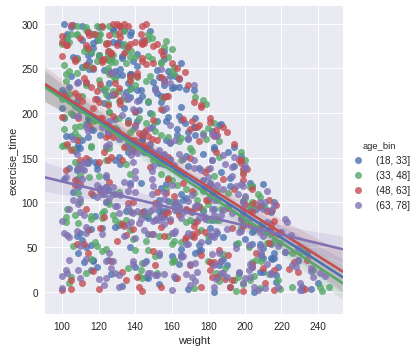

In [15]:
# The oldest age range has the lowest average exercise time across all weight, until around 220ish pounds, then they have the most exercise time
# This says to me that this age range has the most consistent amount of exercise for any weight value
sns.lmplot(data=persons_df, x='weight', y='exercise_time', hue='age_bin');

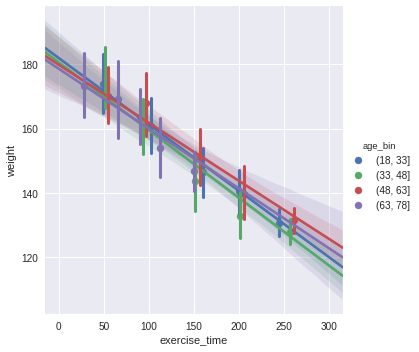

In [16]:
# Across all ages the amount of exercise time goes down relative to weight increase
sns.lmplot(data=persons_df, x='exercise_time', y='weight', hue='age_bin', x_bins=5);

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


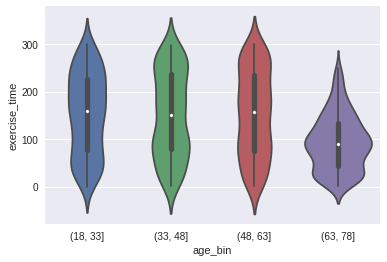

In [17]:
# I think this violin plot tells a similar story:
# While the (63,78] age bin has a lower maximum exercise time, all of its members (across all weights) have the most average exercise time
# Whereas it can be seen to trend much lower for the other three age bins
sns.violinplot(data=persons_df, x='age_bin', y='exercise_time');

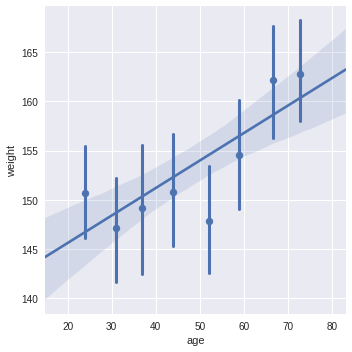

In [18]:
sns.lmplot(data=persons_df, x='age', y='weight', x_bins=8);

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


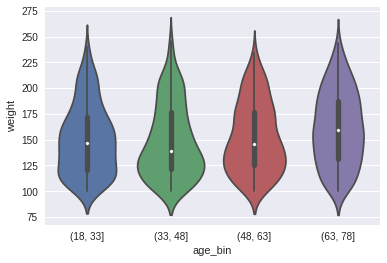

In [19]:
# So, I think that because the highest age bin has the most evenly distributed weight range that would explain
# why the highest age bin also has the most 'even' exercise_time distribution (graphed previously). The graph of 
# exercise time by weight shows that a similar linear correlation exists across all age ranges, so age is more
# of a confounding variable in terms of how much exercise a person will do based on their weight. The other age 
# groups ~seem~ to get more exercise, but its due to the fact that their average weight is much lower. 
sns.violinplot(data=persons_df, x='age_bin', y='weight');

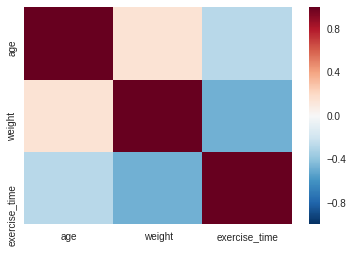

In [20]:
corr_coef = persons_df.corr()
sns.heatmap(corr_coef);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


### Answers
1. The variable types are as follows:
  * ID: discrete & ordinal (There's a notion of comparability and they're of a defined set)
  * age: discrete & ordinal
  * weight: discrete & ordinal
  * exercise_time: discrete & ordinal


2. There is no relationship between the data of each person and their ID. There is a direct linear relationship between weight and exercise_time. There could be a correlation with age and exercise time, but it isn't as strong. The heatmap is an answer to this question in graphical format.

3. The real relationship is between weight and exercise time, whereas age is slightly more of a confounding variable, and the ID is absolutely irrelevant. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)